In [1]:
%load_ext autoreload
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print(tf.__version__)

2.0.0-alpha0


In [3]:
X_train_1 = pd.read_csv('data/dengue_features_train.csv')
y_train = pd.read_csv('data/dengue_labels_train.csv')['total_cases']
attr = list(X_train_1)
attr

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

## Cleaning the noisy training data

In [4]:
def bools_to_indexes(booleans):
    r = []
    for idx, x in enumerate(booleans):
        if x:
            r.append(idx)
    return r

idx = bools_to_indexes(X_train_1['weekofyear'] == 53)
y_train.drop(idx, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_1.drop(idx, inplace=True)
X_train_1.reset_index(drop=True, inplace=True)
X_train_1.shape

(1451, 24)

## Preparing the data

In [5]:
%autoreload
from utils.OurPipeline import create_pipeline

pipeline = create_pipeline(attr)
X_train = pipeline.fit_transform(X_train_1)
N, M = X_train.shape
N, M 

(1451, 20)

# Trying models

In [6]:
score_metric='neg_mean_absolute_error'
n_jobs=-1
iid = False
verbose_level = 2
k_folds=10 
n_iter_search=20

## Simple MLP with Scikit-Learn
* First we will try with a simple Multilayer Perceptron.
* According to the book 'Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems', applying the RELU activation function to all the hidden layers is a good idea.
* Here we will simply be searching through the different initial learning rates
* The ideal number of layers appears to be 7, however the scores are still very high.

#### Defining generic values

In [7]:
activation = 'relu'
train_algorithm = 'adam'
learn_rate_mode = 'adaptive'
learn_rate_val = 0.001
batch_size = 200
max_iter = 5000
random_n = 42
tol_val = 1e-4
n_iter_tol = 20
verb=False

early_stop=True
val_faction = 0.1

params = {
    #'hidden_layer_sizes': [sp_randint(30, 52), sp_randint(16, 30), sp_randint(4, 16)],
    'learning_rate_init': sp_uniform(1e-4, 1)
    
}

### 7-layer perceptron

In [8]:
neurons_per_layer = [20, 15, 10, 7, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   25.7s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[20, 15, 10, 7, 5], learning_rate='adaptive',
              learning_rate_init=0.08729830669792406, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -22.15315382994808)

### 6-layer perceptron

In [9]:
neurons_per_layer = [18, 15, 11, 6]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   23.8s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[18, 15, 11, 6], learning_rate='adaptive',
              learning_rate_init=0.1994901720631599, max_iter=5000, momentum=0.9,
              n_iter_no_change=20, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False),
 -20.896769284991095)

### 5-layer perceptron

In [13]:
neurons_per_layer = [15, 10, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   30.9s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[15, 10, 5], learning_rate='adaptive',
              learning_rate_init=0.020546480378377707, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -21.200566970027445)

### 4-layer perceptron

In [14]:
neurons_per_layer = [15, 5]

mlp = MLPRegressor(hidden_layer_sizes=neurons_per_layer, activation=activation, max_iter=max_iter, solver=train_algorithm, learning_rate=learn_rate_mode, batch_size=batch_size, random_state=random_n, tol=tol_val, verbose=verb, early_stopping=early_stop, validation_fraction=val_faction, n_iter_no_change=n_iter_tol)
MLP_Optimizer = RandomizedSearchCV(mlp, param_distributions=params, cv=k_folds, n_iter=n_iter_search, scoring=score_metric, n_jobs=n_jobs, verbose=verbose_level, iid=iid, return_train_score=True)
MLP_Optimizer.fit(X_train, y_train)
MLP_Optimizer.best_estimator_, MLP_Optimizer.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   14.3s finished


(MLPRegressor(activation='relu', alpha=0.0001, batch_size=200, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=[15, 5], learning_rate='adaptive',
              learning_rate_init=0.37241539488806297, max_iter=5000,
              momentum=0.9, n_iter_no_change=20, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False), -20.65867561536846)

## Simple MLP with Keras on top of Tensorflow
* We will just try the amount of layers (6) which gave the ideal results with the Sci-kit API. 
* The first layer cannot use the activation function RELU given that the data was standardized.
* Sigmoid is okay given that its codomain is between 0 and 1 and that the RELU is linear above 0.

In [10]:
learn_rate = 0.0001
optim = optimizers.Adam(lr=learn_rate)
loss_fun = 'mae'

In [11]:
%autoreload
from utils.MLP import create_mlp
neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()

from utils.print_history_loss import print_history_loss

history_fit = network.fit(X_train, y_train, epochs=500, batch_size=150, verbose=0, validation_split=0.5, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 35)                735       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                900       
_________________________________________________________________
dense_3 (Dense)              (None, 15)                390       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 2,616
Trainable params: 2,616
Non-trainable params: 0
______________________________________________________

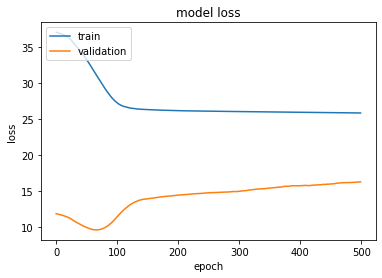

In [12]:
print_history_loss(history_fit)

## Stratified sampling
* The learning curves obtained above are very odd. The validation starts with a very small loss that starts increasing as the model overfits the training data. This is probably because the validation data is very "easy" to predict or all the same. We are going to apply stratified sampling  in order to try and fix this. Y is a continuous variable, therefore stratification is tricky.
* Stratified sampling result was absolutely what we needed as we can see in the learning curves below. It made the train and test data more similar.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
#train_strat, test_strat = sss.split(X_train, y_train)

# Create the bins. Given that y is not uniformly distributed at all (as you can see in the analysis notebook histogram), we created bins every 100 values.
y_sorted = np.sort(y_train)
bins = []
for idx, val in enumerate(y_sorted):
    if (idx % 100) == 0:
        bins.append(val)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y_train, bins)

sss = StratifiedShuffleSplit(n_splits=1, train_size=0.7, random_state=42)
for train_index, test_index in sss.split(X_train, y_binned):
    X_train_strat, X_test_strat = X_train[train_index], X_train[test_index]
    y_train_strat, y_test_strat = y_train[train_index], y_train[test_index]
    
X_train_strat.shape, y_train_strat.shape, X_test_strat.shape, y_test_strat.shape

((1160, 20), (1160,), (291, 20), (291,))

### Training the model with EarlyStopping callback
* Making the model stop training when there doesn't appear to be any improvement

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_49 (Dense)             (None, 35)                735       
_________________________________________________________________
dense_50 (Dense)             (None, 25)                900       
_________________________________________________________________
dense_51 (Dense)             (None, 15)                390       
_________________________________________________________________
dense_52 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 11        
Total params: 2,616
Trainable params: 2,616
Non-trainable params: 0
____________________________________________________

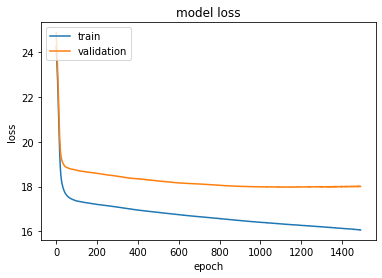

17.974709659541418

In [27]:
%autoreload
from utils.MLP import create_mlp
from utils.print_history_loss import print_history_loss

neurons_per_layer = [35, 25, 15, 10]

network = create_mlp(neurons_per_layer=neurons_per_layer, nr_of_features=M, optim_func=optim, loss_func=loss_fun)
network.summary()


early_stop = EarlyStopping(monitor='val_loss', min_delta=5e-2, patience=500, verbose=2, mode='min', restore_best_weights=True)

history_fit = network.fit(X_train_strat, y_train_strat, validation_data=(X_test_strat, y_test_strat), callbacks=[early_stop], epochs=10000, batch_size=150, verbose=0, shuffle=True)
print_history_loss(history_fit)
min(history_fit.history['val_loss'])

# Recurrent neural networks
* Here we will take advantage of the fact that we are talking about sequential data. For that reason we must **split cities** and we **can't drop rows**.

## Loading the data again
* since we dropped some rows.

In [108]:
X_train_1 = pd.read_csv('data/dengue_features_train.csv')
y_train = pd.read_csv('data/dengue_labels_train.csv')['total_cases']
attr = list(X_train_1)
attr

['city',
 'year',
 'weekofyear',
 'week_start_date',
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

### Splitting the cities

In [109]:
sj = X_train_1['city'] == 'sj'
X_sj_1, y_sj = X_train_1[sj], y_train[sj]
X_iq_1, y_iq = X_train_1[-sj], y_train[-sj]

X_sj_1.shape, y_sj.shape, X_iq_1.shape, y_iq.shape

((936, 20), (936,), (520, 24), (520,))

## Feature selection
* Our plan ahead isto use recurrent neural networks, but in order to have less intensive training we want to remove useless features first
* The `mlp_optim` we are using is the best from the sklearn implementations above
* We can't apply Variance threshold because our attributes have very differente range of values
* In the `f_regression` test, attributes with a p-value above 0.05 is too high and could be removed. As we can see at least 4 should clearly be removed.

### Pvalues

In [110]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr)
X_sj = pipeline_sj.fit_transform(X_sj_1)
pipeline_iq = create_pipeline(attr)
X_iq = pipeline_iq.fit_transform(X_iq_1)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 20), (520, 20))

In [111]:
from sklearn.feature_selection import SelectKBest, f_regression

epsilon = 5e-2

n_iq = sum(f_regression(X_iq, y_iq)[1] > epsilon)
n_sj = sum(f_regression(X_sj, y_sj)[1] > epsilon)
n_sj, n_iq

(9, 7)

#### Removal

In [112]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr, k_best=M - n_sj)
X_sj = pipeline_sj.fit_transform(X_sj_1, y_sj)

pipeline_iq = create_pipeline(attr, k_best=M - n_iq)
X_iq = pipeline_iq.fit_transform(X_iq_1, y_iq)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 13), (520, 11))

#### Correlation removal
* Given that in the analysis notebook we could see there are many attributes with a lot of correlation we implemented a transformer (`CorrelationDeleter`) to remove one of each pair.

In [151]:
%autoreload
from utils.OurPipeline import create_pipeline
pipeline_sj = create_pipeline(attr, k_best=M - n_sj, threshold_corr=0.9)
X_sj = pipeline_sj.fit_transform(X_sj_1, y_sj)

pipeline_iq = create_pipeline(attr, k_best=M - n_iq, threshold_corr=0.9)
X_iq = pipeline_iq.fit_transform(X_iq_1, y_iq)
X_sj.shape, X_iq.shape

/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/miguellobo/Development/UMinho-AA2/.env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


((936, 8), (520, 9))

## Transforming the data into time sequences
* We had to create our own sequence generator because Keras one didn't allow multiple targets per sequence.

In [310]:
X_sj[:10]

array([[ 0.38680303, -1.28201547,  0.04502094, -1.53847521,  0.22876173,
        -1.10040935, -1.27868676, -1.72305369],
       [-0.2408734 , -0.76563752, -0.35088608, -0.35523625, -0.28767639,
        -0.20144297,  0.05994233, -0.26172249],
       [-0.33047568, -0.30470955, -0.12111358,  1.02943204, -0.43113142,
        -0.20144297,  0.35094865,  0.13682239],
       [ 0.89194719, -0.1383596 , -0.46464599,  0.52226931, -0.17291236,
         0.33389656,  0.99116256,  0.46894311],
       [ 1.30273192,  0.29137776, -0.51251525,  0.55858571,  1.00341892,
         1.37427338,  1.98058407,  0.86748799],
       [ 1.35684147,  0.38148398, -0.11013181,  0.39051679, -0.83280552,
         0.78843012,  1.63137648,  0.86748799],
       [ 0.5012683 ,  0.03954242,  0.23086634,  1.01380755, -0.94756954,
         0.29349357,  0.35094865,  0.46894311],
       [-0.43000752,  0.35029336, -0.01129585,  1.42046676, -1.89437277,
         0.97024355,  1.34037015,  0.13682239],
       [-0.88000834,  0.33989649

In [316]:
%autoreload
from utils.OurTimeSequenceGenerator import generate_time_sequence
x,y = generate_time_sequence(X_sj, y_sj, 260)
x.shape, y.shape

array([[-0.33047568, -0.30470955, -0.12111358, ..., -0.20144297,
         0.35094865,  0.13682239],
       [ 0.89194719, -0.1383596 , -0.46464599, ...,  0.33389656,
         0.99116256,  0.46894311],
       [ 1.30273192,  0.29137776, -0.51251525, ...,  1.37427338,
         1.98058407,  0.86748799],
       ...,
       [ 1.45835749, -1.07407804, -0.30414314, ..., -0.24184596,
         0.70015624, -0.99238809],
       [ 0.77007863, -1.33168941, -0.78001999, ..., -0.47416311,
        -0.28926526, -0.59384322],
       [ 0.66583134, -0.29893351, -0.74059824, ...,  0.59651595,
         1.63137648, -0.26172249]])

In [302]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, x.shape[2])))
model.add(layers.Dense(x.shape[1]))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(x, y,
                  steps_per_epoch=500,
                  epochs=1)

500/500 [==============================] - 226s 453ms/step - loss: 28.4456


In [309]:
from sklearn.metrics import mean_absolute_error
#mean_absolute_error(model.predict(x[0].reshape(1,260,8))) 
mean_absolute_error(model.predict(x[10].reshape(1,260,8))[0], y[1])

41.026444240716785

# Loading & preparing test data

In [153]:
X_test_1 = pd.read_csv('data/dengue_features_test.csv')
print(X_test_1.shape)

(416, 24)


In [154]:
sj = X_test_1['city'] == 'sj'
X_test_sj_1 = X_test_1[sj]
X_test_iq_1 = X_test_1[-sj]

X_test_sj_1.shape, X_test_iq_1.shape

((260, 24), (156, 24))

In [155]:
X_test_sj = pipeline_sj.transform(X_test_sj_1)
X_test_iq = pipeline_iq.transform(X_test_iq_1)

X_test_sj.shape, X_test_iq.shape

((260, 8), (156, 9))